In [1]:
# Code from : Self-Driving Car Project Q&A | Advanced Lane Finding 
# https://www.youtube.com/watch?v=vWY8YUayf9Q

In [2]:
import cv2
import numpy as np
import pickle
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

dist_pickle = pickle.load(open("./calib.p", "rb"))
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

In [3]:
def abs_sobel_thresh(img, orient='x',sobel_kernel=3, thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    return binary_output

In [4]:
def color_threshold(image, sthresh=(0,255), vthresh=(0,255)):
    
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= sthresh[0]) & (s_channel <= sthresh[1])] = 1
    
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    v_channel = hsv[:,:,2]
    v_binary = np.zeros_like(v_channel)
    v_binary[(v_channel >= vthresh[0]) & (v_channel <= vthresh[1])] = 1
    
    output = np.zeros_like(s_channel)
    output[(s_binary ==1) & (v_binary == 1)]=1
    
    return output

In [5]:
def window_mask(width, height, img_ref, center, level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),
           max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

In [6]:
import glob
images1 = glob.glob("./test_images/test*.jpg")
images2 = glob.glob("./test_images/straight*.jpg")
images = images1 + images2

print(images)

['./test_images/test2.jpg', './test_images/test6.jpg', './test_images/test5.jpg', './test_images/test3.jpg', './test_images/test1.jpg', './test_images/test4.jpg', './test_images/straight_lines2.jpg', './test_images/straight_lines1.jpg']


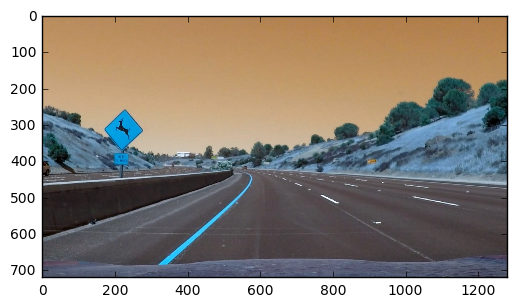

In [7]:
fname = images[0] # "./test2_images/Default Project_45.png"
img = cv2.imread(fname)
plt.imshow(img)

In [8]:
def undistort(img, mtx, dist):
    return cv2.undistort(img, mtx, dist, None, mtx)

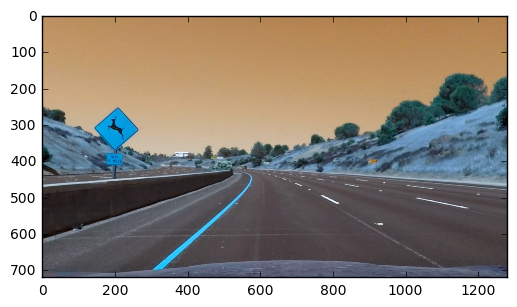

In [9]:
udimg = undistort(img, mtx, dist)
plt.imshow(udimg)

In [10]:
def convert2binary(img):
    binImage = np.zeros_like(img[:,:,0])
    gradx = abs_sobel_thresh(img, orient='x', thresh=(25,255))
    grady = abs_sobel_thresh(img, orient='y', thresh=(10,255))
    c_binary = color_threshold(img, sthresh=(100,255), vthresh=(200,255)) 
    binImage[((gradx == 1) & (grady == 1) | (c_binary == 1) )] = 255
    
    return binImage

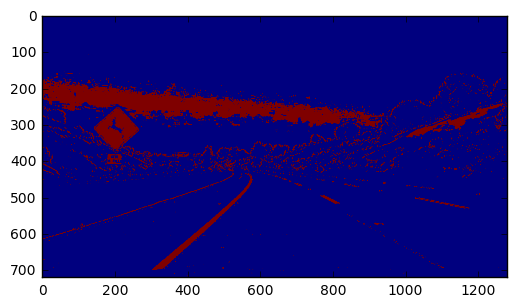

In [11]:
binimg = convert2binary(udimg)
plt.imshow(binimg)

In [12]:
def warp_image(img, bot_width, mid_width, height_pct, bottom_trim):    
    img_size = (img.shape[1],img.shape[0])
    
    src = np.float32([[img.shape[1]*(.5-mid_width/2),img.shape[0]*height_pct],
                      [img.shape[1]*(.5+mid_width/2),img.shape[0]*height_pct],
                      [img.shape[1]*(.5+bot_width/2),img.shape[0]*bottom_trim],
                      [img.shape[1]*(.5-bot_width/2),img.shape[0]*bottom_trim]])
    
    offset = img_size[0]*.25
    dst = np.float32([[offset, 0], [img_size[0]-offset, 0],[img_size[0]-offset, img_size[1]], 
                      [offset ,img_size[1]]])
    
    #print(src, dst)

    # perform the transform
    M = cv2.getPerspectiveTransform(src,dst)
    Minv = cv2.getPerspectiveTransform(dst,src)
    warped = cv2.warpPerspective(img,M,img_size,flags=cv2.INTER_LINEAR)
    
    return M, Minv, warped

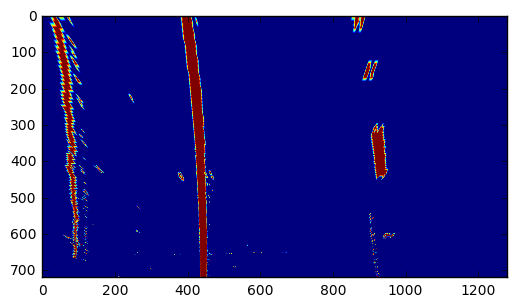

In [13]:
bot_width = 0.75 # %
mid_width = 0.15
height_pct = 0.65
bottom_trim = 0.935
        
M, Minv, warped = warp_image(binimg, bot_width, mid_width, height_pct, bottom_trim)

plt.imshow(warped)

In [14]:
def find_window_centroids(warped, window_width, window_height):
    recent_centers = []
    margin = 25
    smooth_factor = 15
        
    window_centroids = [] 
    window = np.ones(window_width) 

    l_sum = np.sum(warped[int(3*warped.shape[0]/4):,:int(warped.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(warped[int(3*warped.shape[0]/4):,int(warped.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(warped.shape[1]/2)

    window_centroids.append((l_center,r_center))

    for level in range(1,(int)(warped.shape[0]/window_height)):        
        image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):
                                    int(warped.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)

        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin, 0))
        l_max_index = int(min(l_center+offset+margin, warped.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        
        r_min_index = int(max(r_center+offset-margin, 0))
        r_max_index = int(min(r_center+offset+margin, warped.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        
        window_centroids.append((l_center, r_center))

    recent_centers.append(window_centroids)
    return np.average(recent_centers[-smooth_factor:], axis = 0)   

In [15]:
def calculate_perspective_segments(warped, window_centroids, window_width,window_height):
    # Points to draw all left and right windows
    l_points = np.zeros_like(warped)
    r_points = np.zeros_like(warped)

    # Points to find left and right lanes
    rightx = []
    leftx = []

    for level in range(0, len(window_centroids)):
        l_mask = window_mask(window_width,window_height, warped, window_centroids[level][0],level)
        r_mask = window_mask(window_width,window_height, warped, window_centroids[level][1],level)
        # Add center value to right, left lane points lists
        leftx.append(window_centroids[level][0])
        rightx.append(window_centroids[level][1])
        # Add graphic points from window mask to total pixels found
        l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
        r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255
        
    return leftx, rightx, l_points, r_points

In [16]:
def draw_perspective_segments(warped, r_points, l_points):
    template = np.array(l_points+r_points,np.uint8)
    zero_channel = np.zeros_like(template)
    template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8)
    warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8)
    result = cv2.addWeighted(warpage, 1, template, 0.5, 0.0)
    
    return result

In [17]:
def draw_perspective_points(warped, window_height, leftx, rightx):    
    zero_channel = np.zeros_like(warped)
    
    for l in range(len(leftx)):
        y = warped.shape[0] - int(window_height * l)
        xl = int(leftx[l])
        xr = int(rightx[l])
        cv2.circle(zero_channel, (xl,y),5,255,-1)    
        cv2.circle(zero_channel, (xr,y),5,255,-1)    
    
    return zero_channel

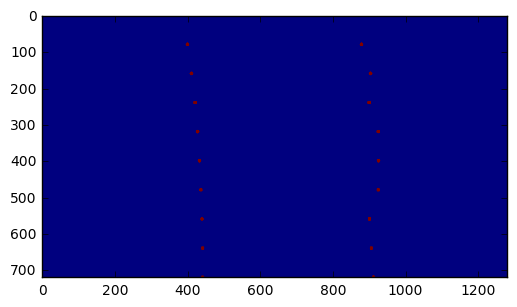

In [18]:
window_width = 25
window_height = 80
xm_per_pix = 4/384 
ym_per_pix = 10/720
    
window_centroids = find_window_centroids(warped, window_width, window_height)
    
leftx, rightx, l_points, r_points = calculate_perspective_segments(warped, window_centroids, 
                                                                       window_width,window_height)
pimg = draw_perspective_points(warped, window_height, leftx, rightx)

plt.imshow(pimg)

In [19]:
def draw_lane_markers(img, yvals, res_yvals, left_fitx, right_fitx, Minv, window_width,window_height):    
    left_lane = np.array(list(zip(np.concatenate((left_fitx-window_width/2,left_fitx[::-1]+window_width/2), axis=0),np.concatenate((yvals,yvals[::-1]),axis=0))),np.int32)
    right_lane = np.array(list(zip(np.concatenate((right_fitx-window_width/2,right_fitx[::-1]+window_width/2), axis=0),np.concatenate((yvals,yvals[::-1]),axis=0))),np.int32)
    inner_lane = np.array(list(zip(np.concatenate((left_fitx-window_width/2, right_fitx[::-1]-window_width/2), axis=0),np.concatenate((yvals,yvals[::-1]),axis=0))),np.int32)
    
    road = np.zeros_like(img)
    road_bkg = np.zeros_like(img)
    cv2.fillPoly(road,[inner_lane],color=[0, 255, 0])
    cv2.fillPoly(road,[left_lane],color=[0,255,255])
    cv2.fillPoly(road,[right_lane],color=[255, 255, 255])
    
    cv2.fillPoly(road_bkg,[left_lane],color=[255, 255, 255])
    cv2.fillPoly(road_bkg,[right_lane],color=[255, 255, 255])
    
    img_size = (img.shape[1],img.shape[0])
    
    road_warped = cv2.warpPerspective(road,Minv,img_size,flags=cv2.INTER_LINEAR)
    road_warped_bkg = cv2.warpPerspective(road_bkg,Minv,img_size,flags=cv2.INTER_LINEAR)

    base = cv2.addWeighted(img, 1.0, road_warped_bkg, -1.0, 0.0)
    result = cv2.addWeighted(base, 1.0, road_warped, 1.0, 0.0)
    
    return result

In [20]:
def fit_curves(warped, leftx, rightx, window_width,window_height):    
    yvals = range(0,warped.shape[0])

    res_yvals = np.arange(warped.shape[0]-(window_height/2),0,-window_height)

    left_fit = np.polyfit(res_yvals, leftx, 2)
    left_fitx = left_fit[0]*yvals*yvals + left_fit[1]*yvals + left_fit[2]
    left_fitx = np.array(left_fitx,np.int32)
    
    right_fit = np.polyfit(res_yvals, rightx, 2)
    right_fitx = right_fit[0]*yvals*yvals + right_fit[1]*yvals + right_fit[2]
    right_fitx = np.array(right_fitx,np.int32)
    
    return yvals, res_yvals, left_fitx,right_fitx 

In [28]:
t="""
diffs = [496.0, 494.0, 490.0, 460.0, 
         477.0, 476.0, 472.0, 469.0, 456.0]

for i in [20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,25,36,37,38,39,40]:
    fname = "./test2_images/Default Project_"+str(i)+".png"
    img = cv2.imread(fname)
    plt.imshow(img)

    udimg = undistort(img, mtx, dist)
    plt.imshow(udimg)

    binimg = convert2binary(udimg)
    plt.imshow(binimg)

    bot_width = 0.75 # %
    mid_width = 0.15
    height_pct = 0.65
    bottom_trim = 0.935

    M, Minv, warped = warp_image(binimg, bot_width, mid_width, height_pct, bottom_trim)

    plt.imshow(warped)

    window_height = 80
    xm_per_pix = 4/384 
    ym_per_pix = 10/720

    window_centroids = find_window_centroids(warped, window_width, window_height)
    leftx, rightx, l_points, r_points = calculate_perspective_segments(warped, window_centroids, 
                                                                           window_width,window_height)
    print(leftx)
    print(rightx)
    print([rightx[di]-leftx[di] for di in range(len(leftx))])
    print("---------------------------------------------------")
    #segimg = draw_perspective_segments(warped, r_points, l_points)

    leftx, rightx
    pimg = draw_perspective_points(warped, window_height, leftx, rightx)

    #plt.imshow(pimg)    
    tolerance = 15.
    
    for pi in range(len(leftx)):
        if abs((rightx[pi] - leftx[pi]) - diffs[pi])> tolerance:
            rightx[pi] = leftx[pi] + diffs[pi]
    
    yvals, res_yvals, left_fitx, right_fitx = fit_curves(warped, leftx, rightx, window_width,window_height)

    result = draw_lane_markers(img, yvals, res_yvals, left_fitx, right_fitx, Minv, window_width,window_height)
    plt.imshow(result)
"""

In [22]:
   
def draw_info(result, warped, yvals, res_yvals, leftx, left_fitx, right_fitx, xm_per_pix, ym_per_pix):
    curve_fit_cr = np.polyfit(np.array(res_yvals,np.float32)*ym_per_pix, np.array(leftx,np.float32)*xm_per_pix, 2)
    curverad = ((1 + (2*curve_fit_cr[0]*yvals[1]*ym_per_pix + 
                      curve_fit_cr[1])**2)**1.5) / np.absolute(2*curve_fit_cr[0])

    camera_center = (left_fitx[-1] + right_fitx[-1])/2
    center_diff = (camera_center-warped.shape[1]/2)*xm_per_pix
    side_pos = 'left'
    if center_diff <= 0:
        side_pos = 'right'

    cv2.putText(result,'Radius of Curvature = '+str(round(curverad,3))+'(m)',(50,50) , 
                cv2.FONT_HERSHEY_SIMPLEX, 1,(255, 255, 255),2)
    cv2.putText(result,'Vehicle is '+str(abs(round(center_diff,3)))+'m '+side_pos+' of center',
                (50,100) , cv2.FONT_HERSHEY_SIMPLEX, 1,(255, 255, 255),2)
    
    return result

In [30]:
diffs = [496.0, 494.0, 490.0, 460.0, 477.0, 476.0, 472.0, 469.0, 456.0]
tolerance = 75.

def process_image2(img, mtx, dist):
    udimg = undistort(img, mtx, dist)
   
    preprocessImage = convert2binary(udimg)
                
    bot_width = 0.75 # %
    mid_width = 0.15
    height_pct = 0.65
    bottom_trim = 0.935
        
    M, Minv, warped = warp_image(preprocessImage, bot_width, mid_width, height_pct, bottom_trim)

    window_width = 25
    window_height = 80
    xm_per_pix = 4/384 
    ym_per_pix = 10/720
    
    window_centroids = find_window_centroids(warped, window_width, window_height)    
    
    leftx, rightx, l_points, r_points = calculate_perspective_segments(warped, window_centroids, 
                                                                       window_width,window_height)
    segimg = draw_perspective_segments(warped, r_points, l_points)        
    
    # fix unrealistic lanes with expected widths
    for pi in range(len(leftx)):
        if abs((rightx[pi] - leftx[pi]) - diffs[pi])> tolerance:
            rightx[pi] = leftx[pi] + diffs[pi]    
    
    #leftx.append(leftx[len(leftx)-1])
    #rightx.insert(0, rightx[len(rightx)-1])
    
    yvals, res_yvals, left_fitx, right_fitx = fit_curves(warped, leftx, rightx, window_width,window_height)

    result = draw_lane_markers(img, yvals, res_yvals, left_fitx, right_fitx, Minv, window_width,window_height)
            
    result = draw_info(result, warped, yvals, res_yvals, leftx, left_fitx, right_fitx, xm_per_pix, ym_per_pix)
    
    return result, udimg, preprocessImage, warped, segimg

def process_image(img):
    result, udimg, preprocessImage, warped, segimg = process_image2(img, mtx, dist)
    return result

In [31]:
import glob
images1 = glob.glob("./test_images/test*.jpg")
images2 = glob.glob("./test_images/straight*.jpg")
images = images1 + images2

for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    result, udimg, binimg, warped, segimg = process_image2(img, mtx, dist)
    cv2.imwrite('./output_images/udimg'+str(idx)+'.jpg', udimg)    
    cv2.imwrite('./output_images/binimg'+str(idx)+'.jpg', binimg)
    cv2.imwrite('./output_images/warped'+str(idx)+'.jpg', warped)
    cv2.imwrite('./output_images/segimg'+str(idx)+'.jpg', segimg)
    cv2.imwrite('./output_images/result'+str(idx)+'.jpg', result)
    

In [25]:
from moviepy.editor import VideoFileClip

Output_video = './project_video_out.mp4'
Input_video = './project_video.mp4'
# Input_video = 'harder_challenge_video.mp4'

clip1 = VideoFileClip(Input_video)
video_clip = clip1.fl_image(process_image) 
video_clip.write_videofile(Output_video, audio=False)

[MoviePy] >>>> Building video ./project_video_out.mp4
[MoviePy] Writing video ./project_video_out.mp4


100%|█████████▉| 1260/1261 [04:11<00:00,  5.99it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project_video_out.mp4 

